##Business Understanding:
1. Is red wine or white wine better in quality?
2. What are differences in properties between white wine and red wine?
3. Can we predict if it's white wine or red wine based on its properties?



##Data Understanding:
1. Get quality Distribution of Red and White wine, and also use Kendall's Rank Correlation to see if there is signifiant quality difference.
2. Examine chemical properties of red and white wines, and use t-test or Wilcoxon-Mann-Whitney test to compare these properties between red and white wines.
3. Based on chemical properties, select features and build a logistic regression model to predict if the wine is red wine or white wine. 


Downloaded winequality_red.csv and winequality_white.csv from https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/ 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
!pip install researchpy
import researchpy as rp
import matplotlib.pyplot as plt
import sys
import scipy.stats as stats
from scipy.stats import ttest_ind
import statsmodels.api as sm
pd.set_option('display.max_columns', None)
from sklearn.metrics import f1_score
from statsmodels.formula.api import logit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Quic Look at the data (red wine and white wine datasets) for completeness and correlations

In [ ]:
white = pd.read_csv("winequality-white.csv", delimiter=';')
#Summary of columns
print(white.describe())    
#Check completeness of data   
print(white.isna().mean())    

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.854788          0.278241     0.334192        6.391415   
std         0.843868          0.100795     0.121020        5.072058   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4898.000000          4898.000000           4898.000000  4898.000000   
mean      0.045772            35.308085            138.360657     0.994027   
std       0.021848            17.007137             42.498065     0.002991   
min       0.009000             2.000000         

In [ ]:
red=pd.read_csv("winequality-red.csv", delimiter=';')
#Summary of columns
print(red.describe())        
#Check completeness of data
print(red.isna().mean())      

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

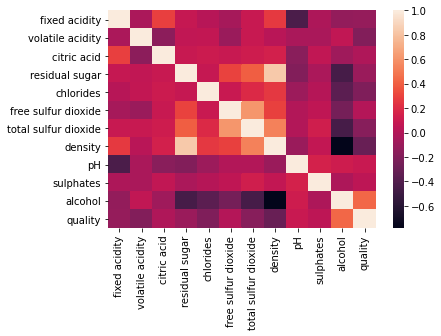

In [ ]:
#See correlation of properties in white wine
sns.heatmap(white.corr())

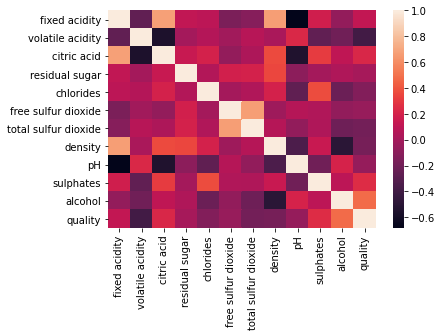

In [ ]:
#See correlation of properties in red wine
sns.heatmap(red.corr())

##1. Quality difference between white and red wines

In [ ]:
#Combine datasets of white wine and red wine
white['Type']= "white"
red['Type'] ="red"
dataall=red.append(white)
print(white.shape)
print(red.shape)
print(dataall.shape)

(4898, 13)
(1599, 13)
(6497, 13)


There are 4898 white wine entries and 1599 red wine entries

Text(0.5, 1.0, 'Wine Quality')

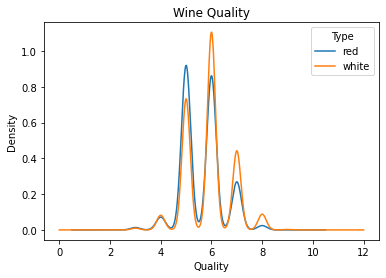

In [ ]:
#Density plot for quality of wines
qualitybyType=dataall.pivot(columns='Type',values='quality')
qualitybyType.plot.density()
plt.xlabel('Quality')
plt.title('Wine Quality')

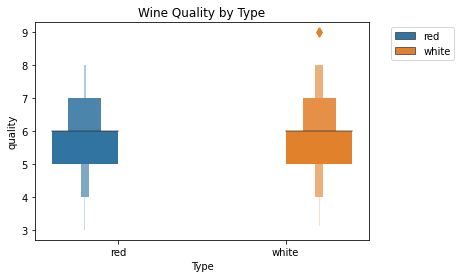

In [ ]:
#Boxplot for quality of wines 
bp = sns.boxenplot(x = "Type", y = "quality", hue ="Type",  
              data = dataall) 
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('Wine Quality by Type')
plt.show()

Measure Kendall's Rank Correlation between qualities of red wine and white wine:

Null hypothesis: There is no quality difference between red wine and white wine

Alternate hypothesis: There is quality difference between red wine and white wine

In [ ]:
crosstab = pd.crosstab(dataall['Type'],dataall['quality'])
print(crosstab)
stats.kendalltau(crosstab.iloc[0],crosstab.iloc[1])

quality   3    4     5     6    7    8  9
Type                                     
red      10   53   681   638  199   18  0
white    20  163  1457  2198  880  175  5


KendalltauResult(correlation=0.8095238095238096, pvalue=0.010714285714285714)

With p value < 0.05, we reject the null hypothese that there is no quality difference between red wine and white wine. Based on previous boxplots, we conclude that white wines generally have higher quality. 

##Property Discrepancies between White wine and Red wine

fixed acidity


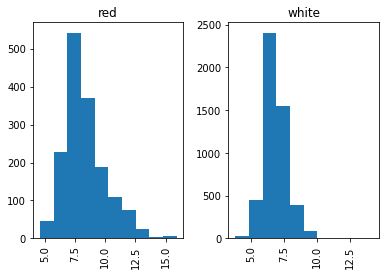

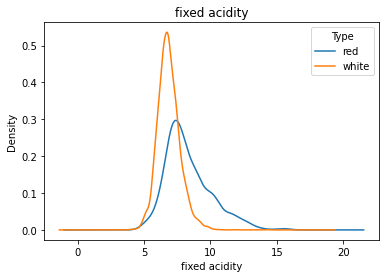

volatile acidity


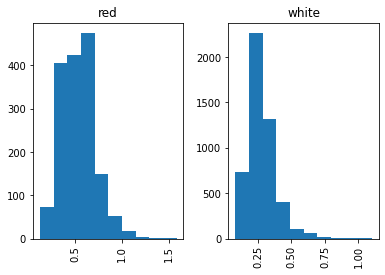

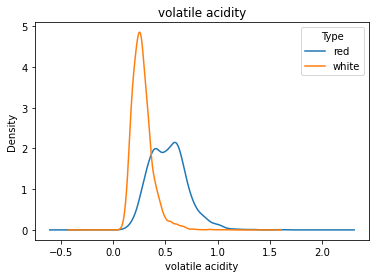

citric acid


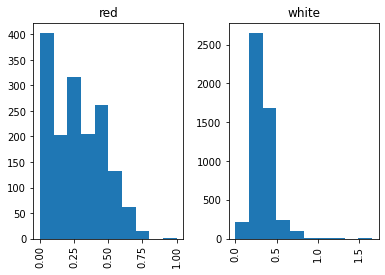

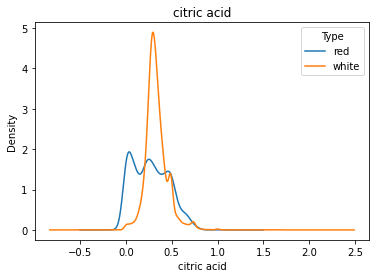

residual sugar


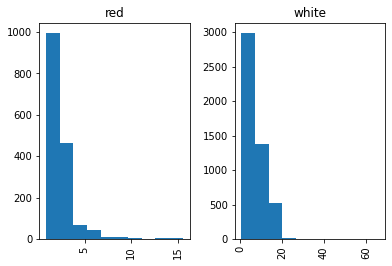

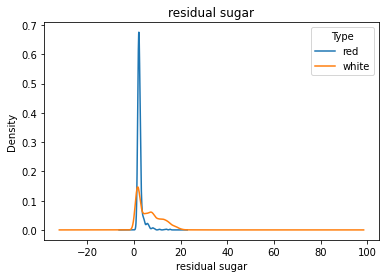

chlorides


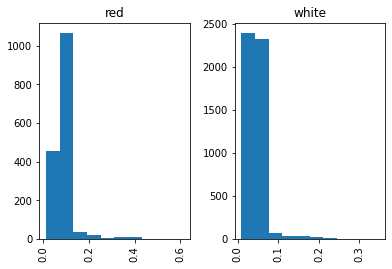

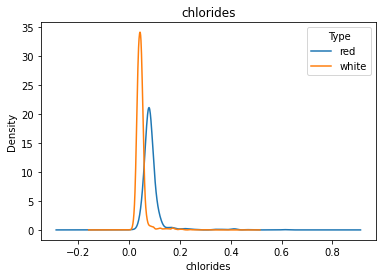

free sulfur dioxide


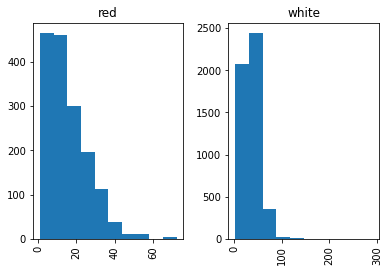

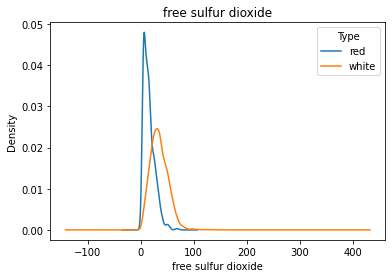

total sulfur dioxide


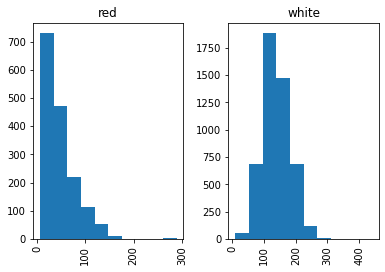

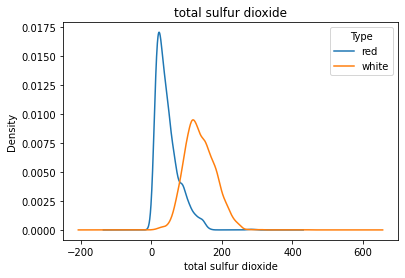

density


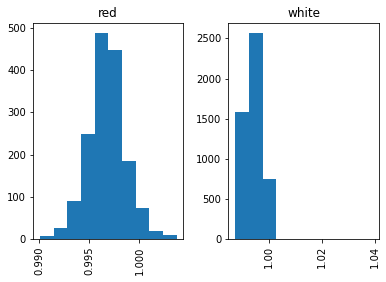

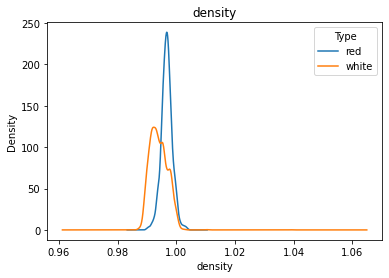

pH


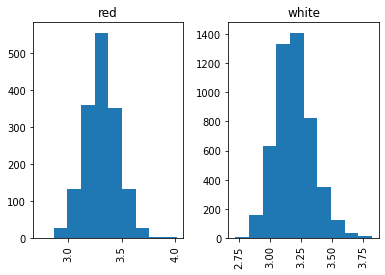

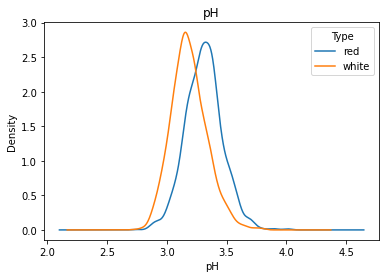

sulphates


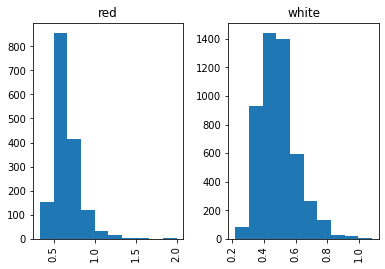

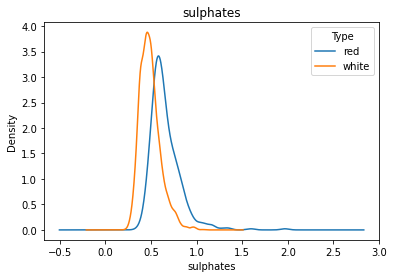

alcohol


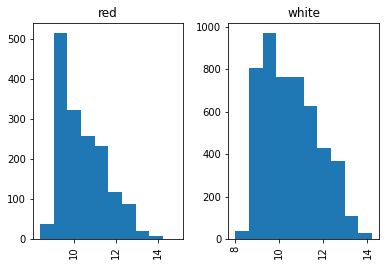

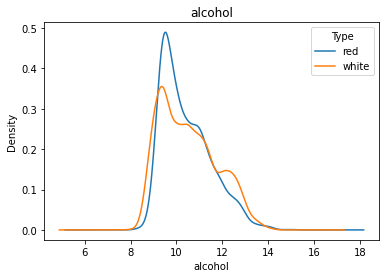

quality


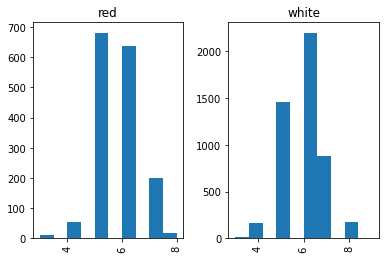

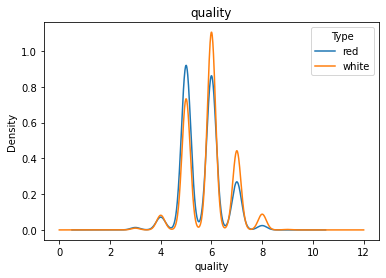

In [ ]:
#Histogram and density plots of all the properties of white and red wines
for i in dataall.columns.drop(['Type']):
  print(i)
  dataall[i].hist(by=dataall["Type"])
  dataall.pivot(columns='Type',values=i).plot.density()
  plt.xlabel(i)
  plt.title(i)
  plt.show()

As we see, many of the distributions for the properties of the wines are not normally distributed, thus to identify properties that are significantly different between white and red wines, we want to see results of non-parametric Wilcoxon-Mann-Whitney test aside from t-test results.

In [ ]:
#Wilcoxon-Mann-Whitney test and t-test results on properties of wines
for i in dataall.columns.drop(['Type', 'quality']):
  print (i)
  stat, p = ttest_ind(white[i], red[i])
  print('T-test result for %s: t=%.3f, p=%.8f' % (i, stat, p))
  stat, p = stats.mannwhitneyu(white[i], red[i])
  print('Wilcoxon-Mann-Whitney result for %s: t=%.3f, p=%.8f\n' % (i, stat, p))


fixed acidity
T-test result for fixed acidity: t=-44.906, p=0.00000000
Wilcoxon-Mann-Whitney result for fixed acidity: t=1693395.000, p=0.00000000

volatile acidity
T-test result for volatile acidity: t=-69.493, p=0.00000000
Wilcoxon-Mann-Whitney result for volatile acidity: t=772278.500, p=0.00000000

citric acid
T-test result for citric acid: t=15.375, p=0.00000000
Wilcoxon-Mann-Whitney result for citric acid: t=3070088.500, p=0.00000000

residual sugar
T-test result for residual sugar: t=29.996, p=0.00000000
Wilcoxon-Mann-Whitney result for residual sugar: t=2569687.000, p=0.00000000

chlorides
T-test result for chlorides: t=-48.123, p=0.00000000
Wilcoxon-Mann-Whitney result for chlorides: t=424886.500, p=0.00000000

free sulfur dioxide
T-test result for free sulfur dioxide: t=43.106, p=0.00000000
Wilcoxon-Mann-Whitney result for free sulfur dioxide: t=1186396.500, p=0.00000000

total sulfur dioxide
T-test result for total sulfur dioxide: t=79.075, p=0.00000000
Wilcoxon-Mann-Whitney

Aside from the amount of alcohol content, all other properties are significantly different between red and white wine. Specifically for the amount of alcohol between red wine and white wine, we see that t test gives a p value of 0.0079, which means that amount of alcohol is also signifanctly different between red wine and white wine. Nonetheless, as we mentioned previously, the alcohol distribution is skewed and thus the Wilcoxon-Mann-Whitney is another measurement we want to look at, and the p-value by Wilcoxon-Mann-Whitney shows that the distribution for the amount of alcohol between red wine and white wine is not significantly different, which is probably more accurate due to the more appropriate test with its distribution.

##Predicting Wine Type

In [ ]:
#Get features and response columns
X=dataall.drop(['Type'], axis=1)
Y=dataall['Type']

In [ ]:
#see feature importance by Chi square test
bestfeatures = SelectKBest(score_func=chi2, k=3)
fit = bestfeatures.fit(X,Y)
featureScores = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(fit.scores_)],axis=1)
featureScores.columns = ['Properties','Score']  #naming the dataframe columns
print(featureScores.sort_values(by=['Score']))

              Properties         Score
7                density      0.008961
10               alcohol      0.957399
8                     pH      5.652320
11               quality     12.122074
2            citric acid     15.118752
4              chlorides     37.398554
9              sulphates     64.271565
1       volatile acidity    221.064880
0          fixed acidity    358.497091
3         residual sugar   3287.056863
5    free sulfur dioxide  14913.554060
6   total sulfur dioxide  87946.248732


Use logistic regression to build model for distinguishing red wine and white wine

In [ ]:
#Use Statsmodel Logit for logistic regression
dataallc=red.append(white)
dataallc.rename(columns={'volatile acidity':'volatile_acidity', 'free sulfur dioxide':'fsd', 'total sulfur dioxide':'tsd', 'fixed acidity':'facidity', 'citric acid':'ca', 'residual sugar':'rs'}, inplace=True)
dataallc.Type[dataallc['Type']=="red"]= 0
dataallc.Type[dataallc['Type']=="white"]= 1
dataallc['Type'] = dataallc['Type'].astype(str).astype(int)

#Separate training and test sets
train, test = train_test_split(dataallc, test_size= .30, random_state=42)

#Use Statsmodel Logit for logistic regression
formula=('Type ~ alcohol + volatile_acidity + density+ fsd + tsd + facidity + ca + rs + pH')
model=logit(formula = formula, data=train).fit()
#model=logit(formula = formula, data=train).fit(method='bfgs')   ###This works worse
model.summary()

Optimization terminated successfully.
         Current function value: 0.029197
         Iterations 15


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Type   No. Observations:                 4547
Model:                          Logit   Df Residuals:                     4537
Method:                           MLE   Df Model:                            9
Date:                Wed, 23 Sep 2020   Pseudo R-squ.:                  0.9472
Time:                        21:36:30   Log-Likelihood:                -132.76
converged:                       True   LL-Null:                       -2512.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2162.7065    195.244     11.077      0.000    1780.035    2545.378
alcohol             -2.0158      0.278     -7.253      0.000      -2.561      -1.471
volatile_acidity    -9.3219      1.405     -6.634      0.000     -12.076      -6.568
density          -2169.6371    199.405    -10.881      0.000   -2560.464   -1778.811
fsd                 -0.0910      0.016     -5.533      0.000      -0.123      -0.059
tsd                  0.0603      0.006      9.488      0.000       0.048       0.073
facidity             0.4758      0.265      1.795      0.073      -0.044       0.995
ca                   1.0787      1.585      0.681      0.496      -2.028       4.185
rs                   1.2807      0.130      9.819      0.000       1.025       1.536
pH                   2.9775      1.663      1.791      0.073      -0.281       6.236
====================================================================================

Possibly complete quasi-separation: A fraction 0.37 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [ ]:
# Evaluate the Model using confusion matrix and f1 score
prediction=model.predict(exog=test)
cutoff=0.5
yprediction=np.where(prediction > cutoff, 1,0)
yactual=test["Type"]
conf_matrix=pd.crosstab(yactual, yprediction, rownames=['Actual'], colnames=['Predict'], margins=True)
print(conf_matrix)

f1_score(yactual, yprediction, average='weighted')

Predict    0     1   All
Actual                  
0        495     7   502
1          8  1440  1448
All      503  1447  1950


0.9923101907758932

The model has a F1 score of 0.99 and can predict wine type by their properties pretty well!

##Conclusion

1. White wine and red wine has a significant difference in quality. White wines in general are with higher quality. 
2. Aside from the alcohol amount of wines that are not significantly different, red wines and white wines have significant differences in their amounts in residual sugar, fixed acidity, volatile acidity, citric acid, pH, density, sulphate, chlorides, density, free sulfur dioxide and total sulfur dioxide.
3. Using the features of the amount of volatile_acidity, density, free sulfur dioxide, total sulfur dioxide, fixed acidity, citric acid, residual sugar, alcohol and pH, we can predict efficiently if its a red wine or white wine.

Reference:

Brownlee, Jason. “Feature Selection For Machine Learning in Python.” Machine Learning Mastery, 27 Aug. 2020, machinelearningmastery.com/feature-selection-machine-learning-python/. 

Gold, Betty. "Vinho Verde Wine: What It Is, Where It's From, How to Serve It." Real Simple, www.realsimple.com/food-recipes/shopping-storing/beverages/vinho-verde.

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.


